# Load cleaned data and preprocessing data here

In [8]:
import pandas as pd

# # Load the CSV file into a DataFrame
# df = pd.read_csv("cleaned_human_face_emotions.csv")

# Load the Parquet file (instead)
df = pd.read_parquet("cleaned_human_face_emotions.parquet")

# Drop a column (for example, the "qa" column)
df = df.drop(columns=["qa"])

# Print the first few rows of the updated DataFrame
print(df.head())

                                               image  emotion
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      sad
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    anger
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  neutral
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...     fear
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  content


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    9400 non-null   object
 1   emotion  9400 non-null   object
dtypes: object(2)
memory usage: 147.0+ KB


Now we just have images in the first column with the emotion in the second column.

In [10]:
from sklearn.model_selection import train_test_split

# Separate feature (X) and label (y)
X = df['image']
y = df['emotion']

# Perform a stratified split to keep class distribution consistent
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 80% training, 20% testing
    random_state=42,    # for reproducibility
    stratify=y          # important for classification
)

# Validation split from X_train if needed:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,     # 25% of the training set (which is 20% of the total) -> 15% overall
    random_state=42,
    stratify=y_train
)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("Validation set size:", len(X_val))

Training set size: 5640
Test set size: 1880
Validation set size: 1880


In [11]:
import io
import numpy as np
from PIL import Image

# Image bytes -> numpy arrays
def decode_images(image_series, target_size=(224, 224)):
    """
    Takes a pandas Series of dictionaries, each containing {'bytes': ...}.
    Decodes them into a list of NumPy arrays (RGB).
    Resizes images to target_size.
    Normalizes pixel values to [0, 1].

    Returns:
      - A NumPy array of shape (num_samples, target_size[0], target_size[1], 3)
    """
    decoded_list = []
    for item in image_series:
        # item should be a dict like {'bytes': b'...'}
        try:
            img_bytes = item['bytes']
            with Image.open(io.BytesIO(img_bytes)) as img:
                # Convert to RGB if needed
                img = img.convert('RGB')
                # Resize
                img = img.resize(target_size)
                # Convert to array
                arr = np.array(img, dtype=np.float32) / 255.0
            decoded_list.append(arr)
        except Exception as e:
            # If there's a bad image, you might want to handle or skip it
            print("Error decoding image:", e)
            # Optionally skip or handle it somehow. For now, let's skip:
            # Continue with the loop
            continue

    return np.stack(decoded_list, axis=0)

print("\nDecoding and resizing images...")

# Decode train set
X_train_array = decode_images(X_train, target_size=(224, 224))
print("X_train_array shape:", X_train_array.shape)

# Decode val set
X_val_array = decode_images(X_val, target_size=(224, 224))
print("X_val_array shape:", X_val_array.shape)

# Decode test set
X_test_array = decode_images(X_test, target_size=(224, 224))
print("X_test_array shape:",  X_test_array.shape)


Decoding and resizing images...
X_train_array shape: (5640, 224, 224, 3)
X_val_array shape: (1880, 224, 224, 3)
X_test_array shape: (1880, 224, 224, 3)


In [12]:
# Encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded   = label_encoder.transform(y_val)
y_test_encoded  = label_encoder.transform(y_test)

print("\nLabel classes found:", label_encoder.classes_)
print("Sample of encoded labels:", y_train_encoded[:10])


Label classes found: ['anger' 'content' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Sample of encoded labels: [6 3 5 6 0 6 7 3 4 0]


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model

# Suppose you have: (224, 224, 3) images
# If you used a different size (e.g. 160x160 for MobileNet), be consistent

num_classes = len(label_encoder.classes_)

# 1) Load a MobileNetV2 (or EfficientNet, ResNet, etc.) without its top layers
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 2) Freeze the base_model so we only train the new head first
base_model.trainable = False

# Define a simple data augmentation pipeline:
data_augmentation = tf.keras.Sequential([
    # Random rotation: factor=0.25 corresponds roughly to ±90° rotation.
    layers.RandomRotation(0.25),
    # Random horizontal flip.
    layers.RandomFlip("horizontal")
])

# 3) Build your classifier on top
model = models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    # Data augmentation layers (only active during training).
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# 4) Train the new top layers
history = model.fit(
    X_train_array, y_train_encoded,
    validation_data=(X_val_array, y_val_encoded),
    epochs=5,
    batch_size=32
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_array, y_test_encoded)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# 5) Fine-tune deeper layers
# Unfreeze part (or all) of base_model and re-compile with a lower learning rate
base_model.trainable = True
# You can selectively unfreeze only some layers:
for layer in base_model.layers[:2]:
    layer.trainable = False

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-5),  # smaller LR for fine-tuning
    metrics=['accuracy']
)

history_fine = model.fit(
    X_train_array, y_train_encoded,
    validation_data=(X_val_array, y_val_encoded),
    epochs=5,
    batch_size=32
)

test_loss, test_acc = model.evaluate(X_test_array, y_test_encoded)
print(f"\nFinal Test Loss after fine-tuning: {test_loss:.4f}")
print(f"Final Test Accuracy after fine-tuning: {test_acc:.4f}")

# Optional: Save the fine-tuned model if desired.
save_path = "MobileNetV2_basemodel_finetuned.h5"
model.save(save_path)
print(f"Model saved to {save_path}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 77s 379ms/step - accuracy: 0.1779 - loss: 2.2257 - val_accuracy: 0.2441 - val_loss: 2.0112
Epoch 2/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 71s 400ms/step - accuracy: 0.2852 - loss: 1.9165 - val_accuracy: 0.3202 - val_loss: 1.8247
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 68s 383ms/step - accuracy: 0.3285 - loss: 1.8139 - val_accuracy: 0.3266 - val_loss: 1.8086
Epoch 4/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 54s 304ms/step - accuracy: 0.3638 - loss: 1.7494 - val_accuracy: 0.3383 - val_loss: 1.7592
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 61s 344ms/step - accuracy: 0.3452 - loss: 1.7501 - val_accuracy: 0.3340 - val_loss: 1.7797
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.3195 - loss: 1.8442

Test Loss: 1.8154
Test Accuracy: 0.3255
Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 193s 992ms/step - accuracy: 0.2684 - loss: 2.0151 - val_accuracy: 0.3330 - val_loss: 1.7909
Epoch 2/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 162s 914ms/step - accuracy: 0.3048 - loss: 1.8365 - val_accuracy


Final Test Loss after fine-tuning: 1.7752
Final Test Accuracy after fine-tuning: 0.3793
Model saved to MobileNetV2_basemodel_finetuned.h5


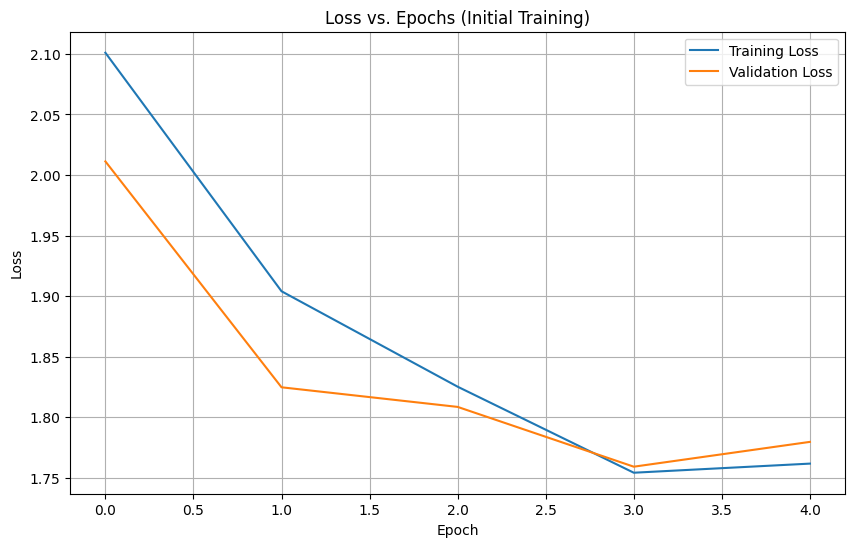

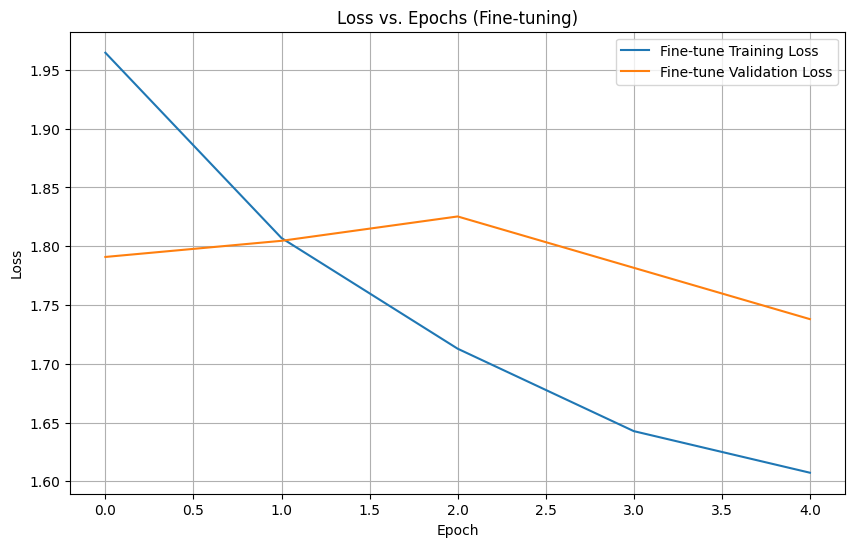


Test Loss: 1.7752
Test Accuracy: 0.3793
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 306ms/step

Confusion Matrix:
[[ 19  63  26  17  19  44   7  40]
 [  6  93  11   9  27  56   2  25]
 [  6  33  54  22  43  35   9  31]
 [  2   9  10  98   5  18   3  91]
 [  0  13   8   2 158  16   2  19]
 [  0  31   9   7  20 137   4  37]
 [  5  26  30  26  26  58  17  49]
 [  3  17   5  25  13  44   3 137]]


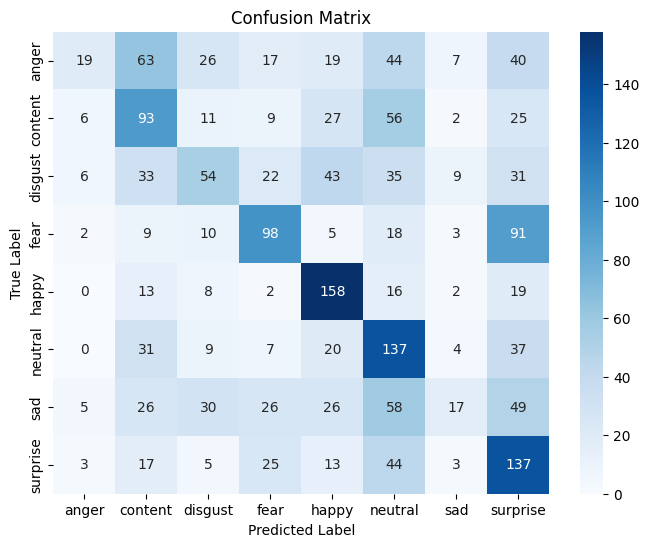


Classification Report:
              precision    recall  f1-score   support

       anger       0.46      0.08      0.14       235
     content       0.33      0.41      0.36       229
     disgust       0.35      0.23      0.28       233
        fear       0.48      0.42      0.44       236
       happy       0.51      0.72      0.60       218
     neutral       0.34      0.56      0.42       245
         sad       0.36      0.07      0.12       237
    surprise       0.32      0.55      0.41       247

    accuracy                           0.38      1880
   macro avg       0.39      0.38      0.35      1880
weighted avg       0.39      0.38      0.34      1880



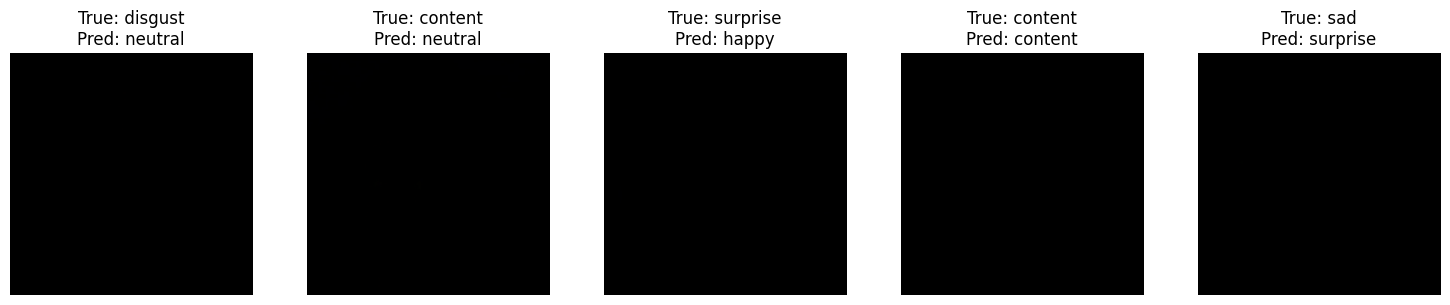

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# ----------------------- PART 3: Visualization -----------------------
# Plot loss versus epochs (for initial training).
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss vs. Epochs (Initial Training)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot loss versus epochs for the fine-tuning phase.
plt.figure(figsize=(10, 6))
plt.plot(history_fine.history['loss'], label='Fine-tune Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tune Validation Loss')
plt.title("Loss vs. Epochs (Fine-tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------- PART 4: Evaluation and Analysis -----------------------
# If you wish to load the saved model (for example, during a separate evaluation run),
# uncomment the following lines:
# model_path = "MobileNetV2_basemodel_finetuned.h5"
# model = load_model(model_path)
# print(f"Loaded model from {model_path}")

# Evaluate the saved (or current) model.
test_loss, test_acc = model.evaluate(X_test_array, y_test_encoded, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Generate prediction probabilities and then convert them to class indices.
y_pred_probs = model.predict(X_test_array)
y_pred = np.argmax(y_pred_probs, axis=1)

# Create and display the confusion matrix.
cm = confusion_matrix(y_test_encoded, y_pred)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(8, 6))
# Use label_encoder.classes_ if available; otherwise use label_classes.
class_names = label_encoder.classes_ if 'label_encoder' in globals() else label_classes
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print the classification report.
report = classification_report(
    y_test_encoded, y_pred, target_names=class_names
)
print("\nClassification Report:")
print(report)

# ----------------------- PART 5: Qualitative Analysis -----------------------
# Display a few random test images along with their predicted and true labels.
num_samples = 5  # number of samples to display
indices = np.random.choice(np.arange(len(X_test_array)), num_samples, replace=False)
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(X_test_array[idx].astype('uint8'))
    true_label = class_names[y_test_encoded[idx]]
    pred_label = class_names[y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()